In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ml-assignment-cl-ii-lab/euroSAT_train_val_test.pkl


In [ ]:
# make the directory
%mkdir logs_cnn

from urllib import request
#download the model from google drive
remote_url = 'https://docs.google.com/uc?export=download&id=1hJAl5nVsKolfiBHTh4pcNWAcDFlbV0mG'
local_file = './logs_cnn/cnn_ckp.pt'
request.urlretrieve(remote_url, local_file)   
# if the model is trained again, the downloaded file will be overwritten

('./logs_cnn/cnn_ckp.pt', <http.client.HTTPMessage at 0x7fc808759710>)

In [ ]:
import pickle
import numpy as np

# for reading and displaying images
from PIL import Image
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import Tensor
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.nn.modules.activation import ReLU

In [ ]:
# make the directory
%mkdir logs_cnn

# setting the random seed for pytorch
torch.manual_seed(1) # ID - 21CS60R01 

mkdir: cannot create directory ‘logs_cnn’: File exists


In [ ]:
# opening the pickled file
with open("/kaggle/input/ml-assignment-cl-ii-lab/euroSAT_train_val_test.pkl", 'rb') as f:
  train_set, val_set, test_set = pickle.load(f)
  print (len(train_set), len(val_set), len(test_set)) # 18792 2808 5400
  print (train_set[0][0].shape, train_set[0][1]) # (3, 64, 64) 7

18792 2808 5400
(3, 64, 64) 7


In [ ]:
# creating data loader
train_loader = data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = data.DataLoader(val_set, batch_size=64, shuffle=True)
test_loader = data.DataLoader(test_set, batch_size=64, shuffle=False)

# **TASK 1:**

In [ ]:
#========= CNN Class ====================

class conv_NN(nn.Module):
    def __init__(self):
      super(conv_NN, self).__init__() #run the init of parent class

      self.cnn_layers = nn.Sequential(
        # input(3*64*64) | conv1 layer | conv1_ouptut(64*32*32) | relu | max_pool | max_pool_output(64*16*16)
        nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride=2,padding=1,bias=False),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),

        #input(64*16*16) | conv2_layer | conv2_output(96*16*16) | relu | max_pool | max_pool_output(96*8*8) 
        nn.Conv2d(in_channels=64,out_channels=96,kernel_size=3,padding=1,bias=False),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),

        #input(96*8*8) | conv2_layer | conv2_output(192*8*8) | relu | max_pool | max_pool_output(192*4*4)
        nn.Conv2d(in_channels=96,out_channels=192,kernel_size=3,padding=1,bias=False),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
      )

      self.fc1 = nn.Linear(192*4*4,1024)
      self.fc2 = nn.Linear(1024,512)
      self.fc3 = nn.Linear(512,10)
      
      # Define proportion of neurons to dropout
      self.dropout = nn.Dropout(0.5)


    def forward(self,x):
      x = self.cnn_layers(x)
      x = x.view(-1,192*4*4)
      x = F.relu(self.fc1(x))
      x = self.dropout(x)
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return x


device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"
  
# Create an instance of the CNN class and allocate it to the device
model = conv_NN().to(device)
# print(model)

In [ ]:
# helper function to train the model
def train(model, device, train_loader,val_loader,loss_criteria,optimizer, epoch):
  
  train_loss = 0
  train_total = 0
  train_correct = 0

  model.train()
  # Process the images in batches
  for batch_idx, (data, target) in enumerate(train_loader):
      
    # Load the input features and labels from the dataset
    data, target = data.to(device), target.to(device)
    
    # Reset the optimizer
    optimizer.zero_grad()
    
    # Forward pass: Pass image data from training dataset, make predictions about class image
    output = model(data)
    
    # Get the loss
    loss = loss_criteria(output, target)

    # Keep a running total
    train_loss += loss.item()

    # scores, predictions = torch.max(output.data, 1)
    train_total += target.size(0)
    train_correct += torch.sum(torch.argmax(output, dim=1) == target)
    # train_correct += int(sum(predictions == target))
  
    # Backpropagate
    loss.backward()

    # Update the neural network weights
    optimizer.step()
            
  train_acc = round((train_correct.item() / len(train_loader.dataset)) * 100, 4)
  print('Epoch [{}], train_loss: {}, train_accuracy: {}'.format(epoch, train_loss/train_total, train_acc), end='')
  print('\n')

  val_loss = 0
  val_correct = 0
  val_total = 0

  model.eval()

  # Process the images in batches
  for batch_idx, (data, target) in enumerate(val_loader):

    # Load the input features and labels from the dataset
    data, target = data.to(device), target.to(device)

    # Forward pass: Pass image data from training dataset, make predictions about class image
    output = model(data)

    # Get the loss
    loss = loss_criteria(output, target)

    # Keep a running total
    val_loss += loss.item()

    val_total += target.size(0)
    val_correct += torch.sum(torch.argmax(output, dim=1) == target)

  val_acc = round((val_correct.item() / len(val_loader.dataset)) * 100, 4)
  print('Epoch [{}], val_loss: {}, val_accuracy: {}'.format(epoch, val_loss/val_total, val_acc), end='')
  print('\n')
  return train_loss,train_acc,val_loss,val_acc

In [ ]:
# Use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# If you don't want to train the model again, don't run the below cell

In [ ]:
# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []
training_acc= []
validation_acc= []
val_loss_min = np.Inf
best_epoch = 0
patience = 10


epochs = 150
for epoch in range(1, epochs + 1):
    train_loss,train_acc,val_loss,val_acc = train(model, device, train_loader,val_loader,loss_criteria, optimizer, epoch)
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    training_acc.append(train_acc)
    validation_loss.append(val_loss)
    validation_acc.append(val_acc)
    
    
    # saving the model with the least validation loss
    if validation_loss[-1]<= val_loss_min:
        # TASK_1 : Deliverable (1)
        checkpoint_path = 'logs_cnn/cnn_ckp.pt'
        val_loss_min = validation_loss[-1]
        best_epoch = epoch
        torch.save(model.state_dict(),checkpoint_path)
#         save_ckp(checkpoint, checkpoint_path)

    #applying the early stopping principle  
    if (epoch - best_epoch) > patience:
      print('Early stopping at epoch {}'.format(epoch))
      break


Epoch [1], train_loss: 0.02799632642917706, train_accuracy: 28.4163

Epoch [1], val_loss: 0.022688761438399638, val_accuracy: 46.047

Epoch [2], train_loss: 0.020534842080413254, train_accuracy: 48.9943

Epoch [2], val_loss: 0.018476839567351546, val_accuracy: 56.7664

Epoch [3], train_loss: 0.017925844760512535, train_accuracy: 56.8487

Epoch [3], val_loss: 0.01646646751128031, val_accuracy: 60.755

Epoch [4], train_loss: 0.016605192655043278, train_accuracy: 60.3927

Epoch [4], val_loss: 0.015117064861320702, val_accuracy: 64.4943

Epoch [5], train_loss: 0.01549016281791117, train_accuracy: 63.2876

Epoch [5], val_loss: 0.014042673266341543, val_accuracy: 68.3761

Epoch [6], train_loss: 0.014277174320308235, train_accuracy: 66.5549

Epoch [6], val_loss: 0.01383992301517742, val_accuracy: 68.4117

Epoch [7], train_loss: 0.013632167087889266, train_accuracy: 68.2737

Epoch [7], val_loss: 0.012544489823854886, val_accuracy: 70.4416

Epoch [8], train_loss: 0.013026829832738996, train_acc

In [ ]:
# # load the saved checkpoint for best model
ckp_path = "logs_cnn/cnn_ckp.pt"
model.load_state_dict(torch.load(ckp_path))

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the model on the validation set: %f %%' %
      (100 * correct / total))


# accuracy on test set
correct = 0
total = 0
predicted_list = []
t_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        _, predicted = torch.max(output.data, 1)
        t_labels.append(labels)
        predicted_list.append(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the model on the test set: %f %%' %
      (100 * correct / total))

Accuracy of the model on the validation set: 89.245014 %
Accuracy of the model on the test set: 87.722222 %


# 

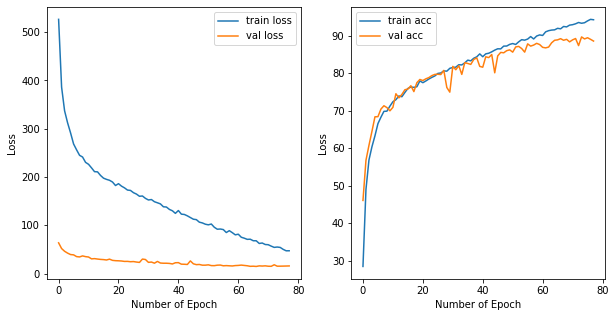

In [ ]:
# plot loss and accuracy
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(training_loss, label="train loss")
plt.plot(validation_loss, label="val loss")
plt.xlabel('Number of Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(training_acc, label="train acc")
plt.plot(validation_acc, label="val acc")
plt.xlabel('Number of Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# putting the predicted labels in a csv file

df=pd.DataFrame(columns=['id','label'])
labels = []
true_labels =[]
for i in range(len(predicted_list)):
    temp_arr = predicted_list[i].cpu().detach().numpy()
    temp_labels = t_labels[i].cpu().detach().numpy()
    for j in temp_arr:
        labels.append(j)
    for j in temp_labels:
        true_labels.append(j)
df['label']=labels
df['id']=[i for i in range(len(labels))]
df.to_csv('predictions_task1.csv',index=False)


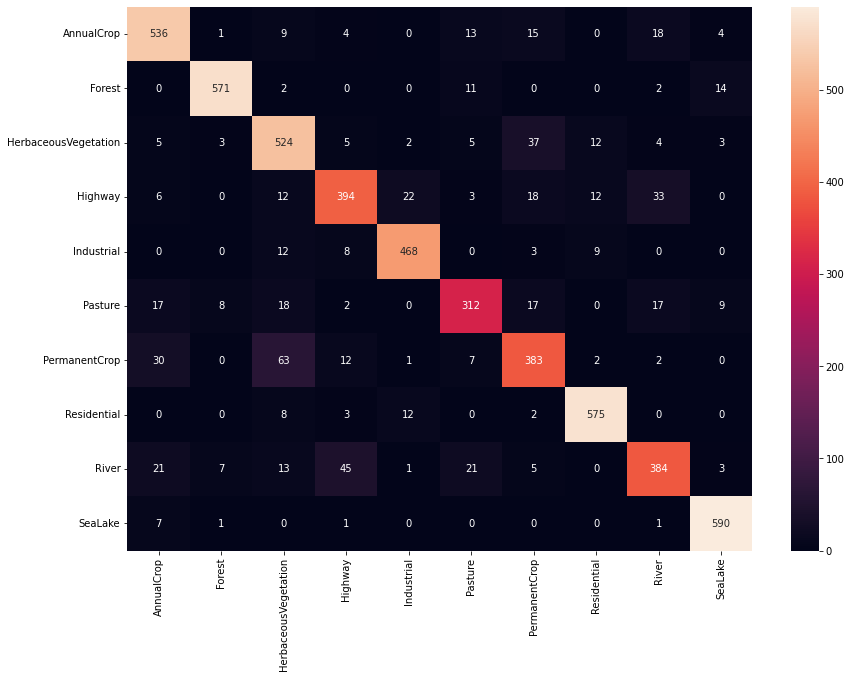

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

with torch.no_grad():
    # iterate over test data
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        output = model(images) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
        'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
# cf_matrix = confusion_matrix(true_labels, labels)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (14,10))
sn.heatmap(df_cm, annot=True,fmt='g')
plt.savefig('output.png')

In [ ]:
report = classification_report(y_true, y_pred,target_names=classes)
print(report)

                      precision    recall  f1-score   support

          AnnualCrop       0.86      0.89      0.88       600
              Forest       0.97      0.95      0.96       600
HerbaceousVegetation       0.79      0.87      0.83       600
             Highway       0.83      0.79      0.81       500
          Industrial       0.92      0.94      0.93       500
             Pasture       0.84      0.78      0.81       400
       PermanentCrop       0.80      0.77      0.78       500
         Residential       0.94      0.96      0.95       600
               River       0.83      0.77      0.80       500
             SeaLake       0.95      0.98      0.96       600

            accuracy                           0.88      5400
           macro avg       0.87      0.87      0.87      5400
        weighted avg       0.88      0.88      0.88      5400

